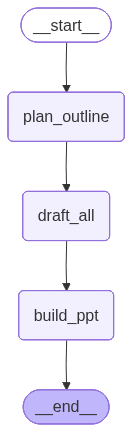

In [2]:
"""
langgraph_slide_maker_loop.py —— LangGraph 三步法（循环版 · 博文友好）

三步：
1) 规划（plan_outline）：先拿大纲（仅 title / subtitle）
2) 研究（draft_all）：按大纲逐页生成要点（用简单 for 循环）
3) 制作（build_ppt）：导出 PPTX

说明：
- 追求可读性与教学友好：不加并发/复杂控制，不做额外容错；Prompt 内嵌。
- 要点字数与数量不限制，只需符合 PPT 风格（短句/短语、可口播、信息清晰）。
"""
import sys

sys.path.append('..')
import json, time, re, os
from pathlib import Path
from typing import List, TypedDict

from openai import OpenAI
from langgraph.graph import StateGraph, START, END
from pptx import Presentation
from pptx.util import Pt

# ===== 配置（直接改这里） =====
API_KEY = os.getenv("DASHSCOPE_API_KEY")
BASE_URL = "https://dashscope.aliyuncs.com/compatible-mode/v1"  # 可替换为你的 OpenAI 兼容端点
MODEL = "qwen-plus"
MAX_SLIDES = 10
OUT_DIR = "output"

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)


# ===== 状态结构 =====
class Slide(TypedDict, total=False):
    title_text: str
    subtitle_text: str
    text: List[str]


class GState(TypedDict, total=False):
    topic: str
    outline: List[Slide]
    slides: List[Slide]
    output_path: str


# ===== 第 1 步：规划大纲 =====

def plan_outline(state: GState) -> GState:
    topic = state.get("topic", "")
    resp = client.chat.completions.create(
        model=MODEL,
        temperature=0.2,
        messages=[
            {"role": "system", "content": "只输出 JSON 数组。"},
            {"role": "user", "content": f"""
请先给出演示文稿大纲，只包含每一页的标题与副标题，严格返回一个 JSON 数组：
每个元素示例：{{"title_text":"标题","subtitle_text":"副标题（可选）"}}
要求：
- 总页数不超过 {MAX_SLIDES}；第 1 页可作为封面。
- 文风符合 PPT：短句/短语、清晰可讲述；不写空话。
- 只返回 JSON 数组本体。

主题：{topic}
"""},
        ],
    )
    state["outline"] = json.loads(resp.choices[0].message.content)
    return state


# ===== 第 2 步：逐页生成要点（简单循环） =====

def draft_all(state: GState) -> GState:
    topic = state.get("topic", "")
    outline = state.get("outline", [])
    slides: List[Slide] = []
    for page in outline:
        title = page.get("title_text", "")
        subtitle = page.get("subtitle_text", "")
        resp = client.chat.completions.create(
            model=MODEL,
            temperature=0.3,
            messages=[
                {"role": "system", "content": "只输出 JSON 对象。"},
                {"role": "user", "content": f"""
请基于给定的页面标题/副标题，为该页生成可直接用于 PPT 的要点。
严格返回一个 JSON 对象：{{"title_text":"...","subtitle_text":"...","text":["要点A","要点B","..."]}}
要求：
- 保持原有标题/副标题表达（允许小幅优化）。
- 要点符合 PPT 风格：短句/短语，信息清晰、可口播；不限制字数与数量。
- 不返回任何解释文字。

主题：{topic}
页面标题：{title}
页面副标题：{subtitle}
"""},
            ],
        )
        slides.append(json.loads(resp.choices[0].message.content))
    state["slides"] = slides
    return state


# ===== 第 3 步：制作 PPT =====

def build_ppt(state: GState) -> GState:
    slides = state.get("slides", [])
    prs = Presentation()

    # 封面
    cover = slides[0] if slides else {"title_text": "未命名", "subtitle_text": ""}
    s0 = prs.slides.add_slide(prs.slide_layouts[0])
    if s0.shapes.title:
        s0.shapes.title.text = cover.get("title_text", "")
    if len(s0.placeholders) > 1:
        try:
            s0.placeholders[1].text = cover.get("subtitle_text", "")
        except Exception:
            pass

    # 内容页
    for page in slides[1:MAX_SLIDES]:
        s = prs.slides.add_slide(prs.slide_layouts[1])
        if s.shapes.title:
            s.shapes.title.text = page.get("title_text", "")
        if len(s.placeholders) > 1:
            tf = s.placeholders[1].text_frame
            bullets = page.get("text") or []
            if bullets:
                tf.text = bullets[0]
                try:
                    tf.paragraphs[0].font.size = Pt(20)
                except Exception:
                    pass
                for b in bullets[1:]:
                    p = tf.add_paragraph();
                    p.text = b;
                    p.level = 0
                    try:
                        p.font.size = Pt(20)
                    except Exception:
                        pass

    # 输出
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    title = (cover.get("title_text") or "deck").strip()
    slug = re.sub(r"[^\w\-]+", "_", title)[:40] or "deck"
    out = Path(OUT_DIR) / f"{slug}_{time.strftime('%Y%m%d-%H%M%S')}.pptx"
    prs.save(out.as_posix())

    state["output_path"] = out.as_posix()
    return state


# ===== LangGraph 装配 =====
workflow = StateGraph(GState)
workflow.add_node("plan_outline", plan_outline)
workflow.add_node("draft_all", draft_all)
workflow.add_node("build_ppt", build_ppt)

workflow.add_edge(START, "plan_outline")
workflow.add_edge("plan_outline", "draft_all")
workflow.add_edge("draft_all", "build_ppt")
workflow.add_edge("build_ppt", END)

slide_graph = workflow.compile()
from IPython.display import Image, display

display(Image(slide_graph.get_graph().draw_mermaid_png()))

In [ ]:
# ===== 运行示例 =====
result = slide_graph.invoke({"topic": "介绍大语言模型：原理、能力、应用与局限"})
print("PPT 输出：", result.get("output_path"))